# Intelligent systems for bioinformatics- Group 1

This work is developed in the ambit of curricular unit intelligent systems for bioinformatics of the Bioinformatic Master by:
- [Beatriz Santos](https://github.com/beatrizsantos1607) (pg46723)
- [Duarte Velho](https://github.com/duartebred) (pg53481)
- [Ricardo Oliveira](https://github.com/ricardofoliveira61) (pg53501)
- [Rita Nobrega](https://github.com/ritanobrega00) (pg46733)
- [Rodrigo Esperança](https://github.com/esperancaa) (pg50923)

This work consists in the analysis of a dataset through the utilization of machine learning algorithms, recurring to Python as the programming language.
The entire analysis is present on a Jupyter Notebook, organized in sections (explained later on) containing succinct explanations of the procedures and decisions taken throughout the analysis.

For this work we selected the [GDSC1](https://tdcommons.ai/multi_pred_tasks/drugres) dataset. This dataset contains the wet lab IC50 for 208 drugs in 1000 cancer cells lines and can be used to design models that can predict drug response since the same compound can have different levels of responses in different patients. With this we aim to design a model that given a pair of drug and cell line genomics profile can predict the drug response and find the best drug to treat certain patient. In this dataset the RMD normalized gene expression was used for cancer lines and the SMILES for drugs. Y is the log normalized IC50.

## Notebook sections
### 1. Preprocessing and data exploration
- Review of all documentation available about the dataset
- Load the dataset and realize an exploratory analysis 
- Prepare the dataset with the generation and selection of features and treatment of the missing values 

This stage corresponds to the 1st section of the Notebook where:
- The dataset must the described according to the documentation
- Summarize the characteristics of the data through an exploratory analysis
- Description of the preprocessing steps justifying the choices
- Include graphics that represent the main characteristics of the dataset

### 2. Non-supervised learning
- Utilization of the adequate visualization and dimensionality reduction technique
-  Application of clustering methods

This stage corresponds to the section 2 of the Notebook where:
- The results must be analyzed and the procedures explain

### 3. Machine Learning
- Compare the behavior of different models/methods of machine learning through the calculation of the performance metrics
- Present the best model for the dataset

This stage correspond to the section 3 of the notebook and all the results must be reported and analyzed in a critical way

### 4. Deep Leaning
- Utilization of deep learning methods similarly to the stage 3

This stage correspond to the section 4 of the notebook and must report the results and have a critical analysis.

All the packages used during this work are listed on the cell below


In [2]:
from tdc.multi_pred import DrugRes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, Descriptors, AllChem, PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
import umap


In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import layers, models

## 1. Preprocessing and data exploration
 The first stage of this work consists of describing the dataset that is going to be used along the project. This stage is crucial to understand the data, its structure, its quality, and potential analysis. Let's start by reviewing all the available documentation.

 ### 1.1 Documentation review
 Recent studies have shown that alterations in cancer genomes influence the clinical response to anticancer therapies. Nowadays, genomic changes are used as molecular biomarkers to identify patients most likely to benefit from a treatment, however many cancer drugs in development or already in use have not been linked to a specific genomic marker that could guide their clinical use to diminish the time needed to treat a patient. 

 The discovery of cancer genome as a potential biomarker was only possible due to the advances in the recent years in high-throughput technologies, in particular, DNA sequencing technologies, that allow the sequencing on a scale that was previously unthinkable. To explore the increased knowledge of cancer genomics, preclinical studies that link the genomic complexity of cancer with functional readouts such as drug sensitivity are required. For these studies, cancer lines derived from many naturally occurring cancer types are essential to mimic the tissue type and genomic context of the cancer, and they also provide an easy system for experimental manipulation for molecular biology and drug discovery. For this reason, several studies have used cancer cell lines to link pharmacological data with genomic information and helped define therapeutic biomarkers as well as to demonstrate that pharmacogenomic profiling in cancer cell lines can be used as a biomarker discovery platform to guide the development of new cancer therapies.

The Genomics of Drug sensitivity in Cancer database, or GDSC for short, was designed to facilitate the study and understanding of the molecular features that influence drug response in cancer cell lines. The database holds datasets of drug sensitivity in cancer cells and links these data to detailed genomic information to facilitate the discovery of molecular biomarkers for drug response. These efforts are expected to, in a near future, provide a complete description of the genomic changes that occur in many cancer types
and profound insights into the origins, evolution and progression of cancer.

In order to download and load the dataset, we will use the `DrugRes` class from the `tdcommons.multi_pred` package. This package will facilitate data access to perform an initial analysis of the dataset, including its structure, format and content. The code presented below was used to download/load the dataset.


In [4]:
# download/load of the dataset and conversion to pandas.dataframe
data = DrugRes(name = 'GDSC1')
GDSC = data.get_data()
# download/load the gene symbols of the transciptomic profile
gene_symbols = data.get_gene_symbols()

# dataframe visualization
GDSC

Found local copy...
Loading...
Done!
Found local copy...
Loading...


,Drug_ID,Drug,Cell Line_ID,Cell Line,Y
0,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,MC-CAR,"[3.23827250519154, 2.98225419469807, 10.235490...",2.395685
1,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES3,"[8.690197905033282, 3.0914731119366, 9.9924871...",3.140923
2,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES5,"[8.233101127037282, 2.82468731112752, 10.01588...",3.968757
3,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES7,"[8.33346622426757, 3.9667571228514302, 9.79399...",2.692768
4,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,EW-11,"[8.39134072442845, 2.9683601858810698, 10.2606...",2.478678
...,...,...,...,...,...
177305,PFI-3,C1[C@@H]2CN([C@H]1CN2C3=CC=CC=N3)/C=C/C(=O)C4=...,SNU-1040,"[8.65368534780164, 2.9238748715081, 10.1278774...",5.353963
177306,PFI-3,C1[C@@H]2CN([C@H]1CN2C3=CC=CC=N3)/C=C/C(=O)C4=...,SNU-407,"[8.57966425274312, 2.77877087774424, 9.7680113...",4.820567
177307,PFI-3,C1[C@@H]2CN([C@H]1CN2C3=CC=CC=N3)/C=C/C(=O)C4=...,SNU-61,"[8.077115751588071, 2.78132536810578, 10.03805...",5.785978
177308,PFI-3,C1[C@@H]2CN([C@H]1CN2C3=CC=CC=N3)/C=C/C(=O)C4=...,SNU-81,"[7.7976988637889, 2.6408995410198797, 9.463400...",5.393454


In [5]:
data.print_stats()

--- Dataset Statistics ---
208 unique drugs.
958 unique cell lines.
177310 drug-cell line pairs.
--------------------------



The dataset download contains the cell line drug sensitivity data. This data was generated from ongoing high-throughput screening performed by the Cancer Genome Project at the Wellcome Trust Sanger Institute and the Center for Molecular Therapeutics at Massachusetts General Hospital.

This database is composed by 5 columns. The first column contains the name of the drug used on the screening, while the second column contains the 1D structure of the drug represented as a SMILES string. The compounds used during the screening are anticancer therapeutics encompassing both targeted agents and cytotoxic chemotherapeutics that are approved drugs already in use in the clinic or drugs undergoing clinical development and in clinical trials. The targeted drugs cover a wide range of targets and processes implicated in cancer biology including receptor tyrosine kinase signalling, cell cycle control, DNA damage response and the cytoskeleton.

The third column contains the name of the cell line used on the screening. The total collection of cell lines available for screening includes around 1000 different cancer cell lines that have been carefully selected to represent the spectrum of common and rare types of adult and childhood cancers of epithelial, mesenchymal and hematopoietic origin. The fourth column contains the raw mean difference (RMD) normalized gene expression profile data of the cell line when subjected to a specific anticancer drug in a vectorized format.

The last column corresponds to the cell line drug sensitivity values, which were measured using fluorescence-based cell viability assays after 72 hours of drug treatment, and dose-response curves were fitted to fluorescence signal intensities over nine drug concentrations. However, the values reported on the dataset are the normalized log values of the half maximal inhibitory concentration (IC50).

Is important to note that the current release of GDSC (3rd December of 2024) includes drug sensitivity data for 208 anticancer drugs and about 180000 cell line-drug interactions. This is the largest public resource available on drug sensitivity in cancer cells with ongoing screening with releases occurring every 4 months. Each new release these results are updated and new data for existing drug as well as data for new drugs screened is added.


In [6]:
# loading of extra information about the cell lines and drugs
cell_lines = pd.read_csv("data/Cell_listTue Dec 3 15_39_17 2024.csv")
drugs = pd.read_csv("data/Drug_listTue Dec 3 15_39_27 2024.csv")

# filtering the dataset to only include cell lines and drugs that are in the current release of GDSC1
## filtering cell lines
cell_line_idx = []
for cell_name in np.unique(GDSC["Cell Line_ID"]):
    idx = np.where(cell_lines["Cell line Name"]==cell_name)[0]
    if len(idx) != 0:
        cell_line_idx.append(idx[0])

cell_line_idx = np.array(cell_line_idx)
cell_line = cell_lines.iloc[cell_line_idx]

## filtering drugs
drug_idx = []
for drug_name in np.unique(GDSC["Drug_ID"]):
    idx = np.where(drugs[" Name"]==drug_name)[0]
    if len(idx) != 0:
        drug_idx.append(idx[0])

drug_idx = np.array(drug_idx)
drugs = drugs.iloc[drug_idx]
drugs = drugs.iloc[:,1:6]

print("Cell line data frame shape:",cell_line.shape)
print("Drug data frame shape:",drugs.shape)


Cell line data frame shape: (941, 8)
Drug data frame shape: (208, 5)


#### 1.1.1 Cell line information
On the code presented above extra information about the cell lines and the drugs used was loaded as pandas data frame. The original files were retrieved from the [GDSC website](https://www.cancerrxgene.org/). Afterward, both data frames were filtered to only include cell lines and drugs that are in the current release of GDSC1, since the datasets used comprise the information for either GDSC1 and GDSC2.

The cell line data frame is composed of 941 rows that represent all the cell lines, and 8 different columns. The first column contains the name attributed to each cell line, while the second and third columns contain the corresponding **Model ID** and **Cosmic ID**. The Model ID is a unique identifier used to represent a specific experimental model to track and link specific experimental setups across different databases and is particularly useful to organize and reference research data accurately, especially when comparing different cancer models and their responses to treatments or mutations. A Model ID number can be attributed to cell lines, genetically modified organisms, or organoids, however in our dataset the model ID refers only to cell lines. In addition, the Cosmic ID is a unique identifier assigned to a specific cell line in the Cosmic cell lines project, which is part of a larger Cosmic database that collects data on somatic mutations in cancer across a variety of tissues and conditions, being useful to more detailed information about a cell line, such as mutations, genomic profiles, etc.

The TCGA classification (4th column) categorizes the cancer types based on genomic data provided by **The Cancer Genome Atlas** project. This type of classification is more detailed than the traditional classification since it relies on molecular features, such as copy number alterations, gene expression, and chromosomal aberrations to group cancer into distinct subtypes instead of relying on pathological features. For example, the usage of the traditional classification can lead to different types of cancer such as Lung Squamous Cell Carcinoma and Lung Adenocarcinoma to be classified as lung cancer. However, the molecular profile allows the creation of more detailed subtypes of lung cancer, which considerably improved the understanding of cancer. In our dataset, there are present 31 unique TCGA classifications that can be used as input for machine learning models to uncover there is any relationship between the TCGA classification and drug sensitive.

The fifth and sixth columns represent the Tissue and Tissue subtype, respectively. The tissue column represents the system from where the cell line was obtained, while the tissue subtype column represents the specific subdivision of the tissue from where the cell line was obtained. In this dataset, the cell lines were obtained from 13 different tissues, and 55 different tissue subtypes.

The last two columns represent the dataset where the cell line can be found and the number of drugs tested for each cell line, respectively.


In [7]:
cell_line

,Cell line Name,Model ID,COSMIC ID,TCGA Classfication,Tissue,Tissue sub-type,Datasets,number of drugs
0,22RV1,SIDM00499,924100,PRAD,urogenital_system,prostate,GDSC1,353
2,23132-87,SIDM00980,910924,STAD,digestive_system,stomach,GDSC1,344
4,42-MG-BA,SIDM00982,687561,GBM,nervous_system,glioma,GDSC1,345
6,451Lu,SIDM01240,1287706,SKCM,skin,melanoma,GDSC1,352
8,5637,SIDM00807,687452,BLCA,urogenital_system,bladder,GDSC1,347
...,...,...,...,...,...,...,...,...
1929,YT,SIDM00410,946358,ALL,blood,lymphoid_neoplasm_other,GDSC1,387
1931,ZR-75-30,SIDM00971,909907,BRCA,breast,breast,GDSC1,341
1933,huH-1,SIDM00586,1298146,LIHC,digestive_system,liver,GDSC1,352
1935,no-10,SIDM00574,908452,LGG,nervous_system,glioma,GDSC1,393


#### 1.1.2 Drug information

The drug data frame is composed of 208 rows that represent all the drugs used on the study, and 5 different columns. The first column contains the name attributed to each drug, while the second contains other synonyms used to refer to the drug. The third column (Targets) contains the information about the target which the drug was designed to affect. The **target pathway** column stores the infromation about the pathway affected by the drug giving information of which pathway is going to be affected by the treatment. The last column contains the PubChem ids to gather more information about the compounds to perform a more in depth analysis of each drug.

In [8]:
drugs

,Name,Synonyms,Targets,Target pathway,PubCHEM
0,(5Z)-7-Oxozeaenol,"5Z-7-Oxozeaenol, LL-Z1640-2",TAK1,"Other, kinases",9863776
4,5-Fluorouracil,5-FU,Antimetabolite (DNA & RNA),Other,3385
20,A-443654,KIN001-139,"AKT1, AKT2, AKT3",PI3K/MTOR signaling,10172943
21,A-770041,KIN001-111,"LCK, FYN","Other, kinases",9549184
29,AICA Ribonucleotide,"AICAR, N1-(b-D-Ribofuranosyl)-5-aminoimidazole...",AMPK agonist,Metabolism,65110
...,...,...,...,...,...
683,YM201636,"YM-201636, YM 201636",PIKFYVE,PI3K/MTOR signaling,9956222
684,Z-LLNle-CHO,"Z-L-Norleucine-CHO, Gamma-Secretase Inhibitor 1",gamma-secretase,Other,16760646
688,ZM447439,"ZM-447439, ZM 447439","AURKA, AURKB",Mitosis,9914412
690,ZSTK474,"KIN001-167, ZSTK-474, ZSTK 474",PI3K (class 1),PI3K/MTOR signaling,11647372


### 1.2 Dataset exploration and preparation

Data exploration and preparation is a vital aspect on ML workflow since ML is a data-driven approach and thereby the quality of the dataset choosen is going to have a direct impact on the performance and generalization ability of the model. We are going to start by exploring the cell line information to identify potential characteristics that can be useful later on and to remove noise or missing data

#### 1.2.1 Cell line data exploration

The number of drugs tested for each cell line is a important factor that needs to be taken into account since a low number of drugs tested can cause noise for the models instead of providing useful and valuable information.
Analysing the number of drugs tested for each cell line it is possible to see that the minimun value is 1. This can be problematic since a single drug test is not likely to provide enough information for a machine learning method to find meaninful patterns on the data. In addition, this data point can have a negative effect on the model, since it can be a source of noise and therefore must be removed.

On the other hand, we observed that the average number of drug tests for each cell line is around 346 with the maximum number being 403. However, this information alone is not enough to provide a general overview of the number of drug tested and therefore we generated a box plot to identify outliers that also contribute for the dataset noise.


In [9]:
cell_line.describe()[" number of drugs"]

count    941.000000
mean     346.339001
std       52.803075
min        1.000000
25%      342.000000
50%      350.000000
75%      386.000000
max      403.000000
Name:  number of drugs, dtype: float64

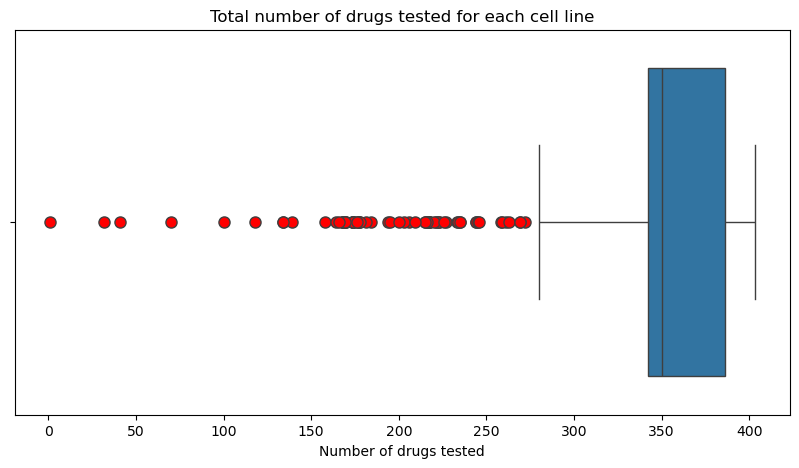

In [10]:
# define the size of the plot
plt.figure(figsize=(10, 5))
# create the boxplot highlighting the outliers with a red marker
sns.boxplot(data = cell_line, x=" number of drugs", orient="h",flierprops=dict(markerfacecolor='red', marker='o', markersize=8))
# defines the title of the box plot
plt.title('Total number of drugs tested for each cell line')
# sets the x-axis label
plt.xlabel('Number of drugs tested')
# generates the plot
plt.show()

In [11]:
# calculates the 1st and 3rd quantile
Q1 = cell_line[" number of drugs"].quantile(0.25)
Q3 = cell_line[" number of drugs"].quantile(0.75)

# calculate the Interquartile range (IQR)
IQR = Q3 - Q1

# calculate the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound_severe = Q1 - 3 * IQR
upper_bound_severe = Q3 + 3 * IQR


# Identify and count the number of outliers
num_outliers = len(cell_line[(cell_line[" number of drugs"] < lower_bound) | (cell_line[" number of drugs"] > upper_bound)])
severe_outliers = cell_line[(cell_line[" number of drugs"] < lower_bound_severe) | (cell_line[" number of drugs"] > upper_bound_severe)]

print(f"Number of outliers: {num_outliers}")
print(f"Number of severe outliers: {len(severe_outliers)}")


Number of outliers: 69
Number of severe outliers: 39


By analysing the box plot of the number of drugs tested for each cell lines is visiable the presence of outliers, more precisely 69 outliers. Outilers can have a significant impact on ML methods since they can impact model performance by increasing the variance of the model resulting in a model that does not generalize well to unseen data or that is overly influenced by the outliers increasing the model bias. To minimize the effects of the outliers on the final model, we defined that a good tradeoff between the number of outliers and the number of samples for training will be the removal of all severe outliers since some noise in the dataset can also be useful for the creation of robust models by forcing the model to focus on the most important patterns specially for more advanced ML methods such as deep learning. By following this approach, we were able to remove 39 severe outliers from the dataset retaining 902 cell lines.

Number of cell lines on the filtered cell line dataframe: 902
count    902.000000
mean     354.552106
std       34.425410
min      215.000000
25%      344.000000
50%      351.000000
75%      386.000000
max      403.000000
Name:  number of drugs, dtype: float64


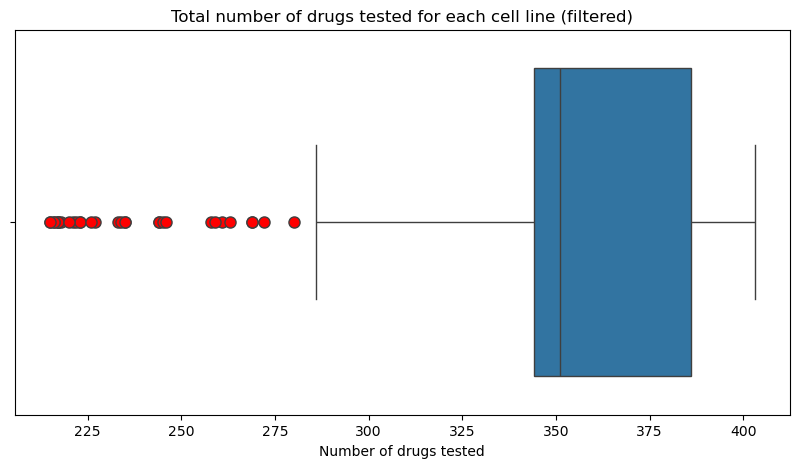

In [12]:
# removing the severe outliers from the cell line dataframe
filtered_cell_line = cell_line.drop(severe_outliers.index, inplace= False)

print("Number of cell lines on the filtered cell line dataframe:", filtered_cell_line.shape[0])
print(filtered_cell_line.describe()[" number of drugs"])

# define the size of the plot
plt.figure(figsize=(10, 5))
# create the boxplot highlighting the outliers with a red marker
sns.boxplot(data = filtered_cell_line, x=" number of drugs", orient="h",flierprops=dict(markerfacecolor='red', marker='o', markersize=8))
# defines the title of the box plot
plt.title('Total number of drugs tested for each cell line (filtered)')
# sets the x-axis label
plt.xlabel('Number of drugs tested')
# generates the plot
plt.show()

The original dataset, as described above, do not contain a lot of features that can be used for model training. This can become a negative factor in the model performance since meaniful features are crucial to capture the underlying patterns present on the dataset during the training process. The lack of meaniful features is most likely going to result on a underfitted model with high bias and poor performance specially for complex relationships like the ones present on biological data where multiple factors influence the cell activities and biochemestry.
To overcome this limitation of our dataset and prevent underfitting we explored extra information about the cell lines that is not included on the original dataset. 

First, we looked into the TCGA classification data as a potential feature. The TCGA classification is based on extensive molecular profilling and thereby can provide biologically meaningful categories for each cell line that help ML models to learn patterns related to cancer behaviors to certain drug treatments. However, when we analised the TCGA classification of the filtered cell lines, we observed that around 20% of the cell lines have **unkown** TCGA classification. For this reason, we considered that the TCGA classification would not result in a valuable feature and would significantly reduce the number of examples that can be used to train the models resulting on a higher negative impacte than positive.


In [13]:
# gives the percentage of cell lines with a certain TCGA classification
filtered_cell_line[" TCGA Classfication"].value_counts(normalize= True)[0:5]

 TCGA Classfication
UNCLASSIFIED    0.188470
LUAD            0.066519
SKCM            0.056541
SCLC            0.055432
BRCA            0.052106
Name: proportion, dtype: float64

We therefore turned our attention to the tissue type from where the cell lines were extracted. This information is important because tissue types can influence the drug sensitivity of cancer due to molecular alterations in the cancer cells, since different tissues often have distinct mutations profiles and gene expression patterns that significally affect how cancer cells will respond to a specific drug. For this reason, tissue type is also a potential feature that can help the model capturing the hidden patterns of the cell lines that can be used to predict with more accuracy the drug sensitivity.

By explorating the tissue type information we observed that 100% of the cell lines have this information without the presence of missing values. By the pie plot visualization of the tissue type classification, we observed that our dataset covers common and rare types of cancer which is important to enhance ML generalization ability. However, some types of cancer, such as thyroid cancers (2%), do not have a significant representation in the data which can reduce the prediction accuracy of the model for this types of cancer. 
With this analysis, we decided that the tissue type has the potential to be a meaninful feature that will help ML models to capture the relationships between different types of cancer and drug sensitivity.

 Tissue
lung                    0.192905
blood                   0.165188
urogenital_system       0.108647
digestive_system        0.096452
nervous_system          0.090909
aero_digestive_tract    0.084257
skin                    0.059867
breast                  0.053215
bone                    0.039911
kidney                  0.035477
pancreas                0.034368
soft_tissue             0.022173
thyroid                 0.016630
Name: proportion, dtype: float64


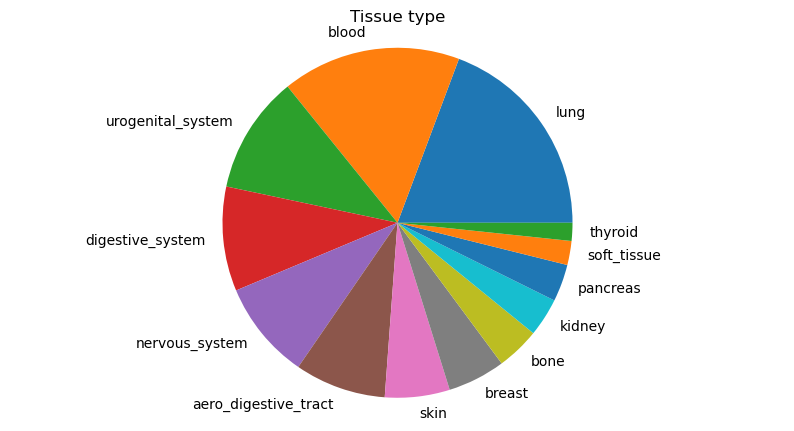

In [14]:
print(filtered_cell_line[" Tissue"].value_counts(normalize= True))

plt.figure(figsize=(10, 5))
# Create a pie chart
plt.pie(filtered_cell_line[" Tissue"].value_counts(normalize= True), labels = filtered_cell_line[" Tissue"].value_counts(normalize= True).index)
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
# Defines the pieplot title
plt.title('Tissue type')
# Display the chart
plt.show()


Finally, we also considered the tissue sub-type as a potential feature. However, when we explored more in depth this information we detected some potential problems that made this characteristic less apealing to use as a feature. The main reasons for excluding this feature are data availability and dimensionality.

**Data availability** would probably become a problem in our future work since our dataset includes some rare types of cancer, such as adrenal gland cancer (less than 1% in our dataset), that are not commonly found. This problem will create a unbalanced dataset that will likely produce models that tend to overfitt to more common types of cancer, by the lack of data from rare types, resulting in model with lower generalization power.

**Dimensionality** would certanly become a hard problem to overcome, because in the human body there is a vast diversity of tissues sub-types, in our dataset we have 55 different tissue sub-types analysied. The incorporation of this information could lead to high-dimensional data which could result in models that have difficulties to learn meaningful information from the dataset without overfitting.

For the reasons presented above we decided that the utilization of tissue sub-type would bring more disadvantages than benefits


In [15]:
tissue_sub_type = filtered_cell_line["Tissue sub-type"].value_counts(normalize= True)

print("Number of different tissues sub-types:", len(np.unique(filtered_cell_line["Tissue sub-type"])))
print("\n","*************************")
print("Top 5 most commun tissue sub-types:\n",tissue_sub_type[0:5])
print("\n","*************************")
print("Top 5 most rare tissue sub-types:\n",tissue_sub_type[-5:])

Number of different tissues sub-types: 55

 *************************
Top 5 most commun tissue sub-types:
 Tissue sub-type
lung_NSCLC_adenocarcinoma    0.069845
melanoma                     0.056541
glioma                       0.055432
lung_small_cell_carcinoma    0.055432
breast                       0.053215
Name: proportion, dtype: float64

 *************************
Top 5 most rare tissue sub-types:
 Tissue sub-type
anaplastic_large_cell_lymphoma    0.002217
uterus                            0.002217
digestive_system_other            0.001109
lung_other                        0.001109
adrenal_gland                     0.001109
Name: proportion, dtype: float64


#### 1.2.2 Drug data exploration
The other important factor on the drug sensitivity of the cancer cell lines is the type of  drug used. The original dataset also does not provided a lot of meaningful information about the drugs used on this project so we decided to explore extra information about the drug used on this project. However, the drugs dataframe also does not provide meaningful information about the drugs. Similarly to tissue sub-types in cell lines, target information to each drug also presents dimensionality and data unbalance problems that prevent this feature to be used efficiently by the models during the training phase.

In [16]:
print("Number of unique drug tragets:",len(np.unique(drugs[" Targets"])))

Number of unique drug tragets: 172


The other potential feature that could be used is target pathway. This feature has 23 different pathways targeted by the 208 drugs used on this project. However, when analyzing the percentage of each pathway is visible that the drugs dataset is unbalanced and on top of that around 25% of the pathway data is not useful since it only refers to "others", something that won't be useful or give important highlights for the model.

This is a potential problem since we don't have enough information about the drugs used on the project that can be used as features to train ML models and learn the relationships between the drug characteristics and drug sensitivity of the cell lines. However, since we the SMILES representation of each drug is possible to generate useful features.

Number of unique drug traget pathways: 23

 *************************
Top 5 common targeted pathways:
  Target pathway
Other                  0.134615
Other, kinases         0.129808
RTK signaling          0.125000
PI3K/MTOR signaling    0.081731
ERK MAPK signaling     0.057692
Name: proportion, dtype: float64

 *************************
Top 5 most rare targeted pathways:
  Target pathway
Hormone-related                  0.009615
WNT signaling                    0.009615
ABL signaling                    0.009615
Chromatin histone methylation    0.009615
IGF1R signaling                  0.004808
Name: proportion, dtype: float64


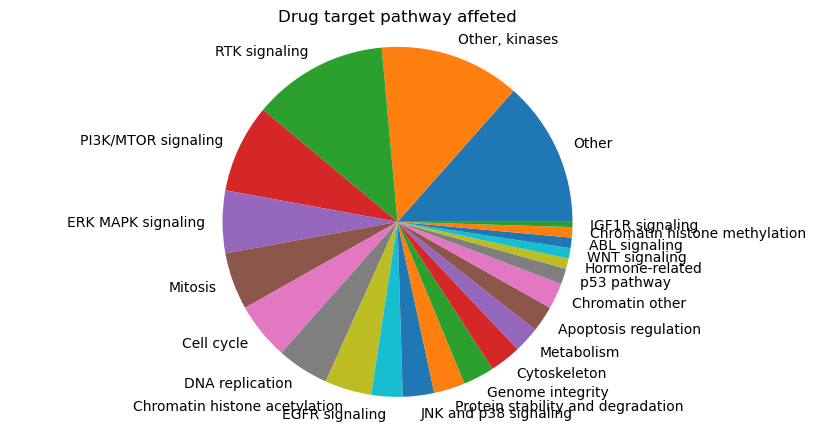

In [17]:
target_pathways = drugs[" Target pathway"].value_counts(normalize=True)

print("Number of unique drug traget pathways:", len(np.unique(drugs[" Target pathway"])))
print("\n","*************************")
print("Top 5 common targeted pathways:\n", target_pathways[0:5])
print("\n","*************************")
print("Top 5 most rare targeted pathways:\n",target_pathways[-5:])


plt.figure(figsize=(10, 5))
# Create a pie chart
plt.pie(drugs[" Target pathway"].value_counts(normalize=True), labels = drugs[" Target pathway"].value_counts(normalize=True).index)
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
# Defines the pieplot title
plt.title('Drug target pathway affeted')
# Display the chart
plt.show()

#### 1.2.3 Feature generation and data preparation

As refered in the last section, drugs present on this dataset don't have useful features so in this section we are going to generate new features that can give useful insights to uncover hidden patterns on the underlying data. Before starting we need to add the SMILES string to the drug dataframe. We opted to create a new drugs dataframe since the extra information found is not useful for our applications.

In [18]:
# extraction of the drug name and respective SMILES string from the original dataset
drug_smile = {}
for drug in np.unique(GDSC["Drug_ID"]):
    drug_smile[drug] = np.unique(GDSC[GDSC["Drug_ID"] == drug]["Drug"])

# creation of canonicalized SMILES and removal of stereochemistry
for drug, smile in drug_smile.items():
    mol = Chem.MolFromSmiles(smile[0])
    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
    canonical_no_stereo = Chem.MolToSmiles(mol, isomericSmiles=False)
    drug_smile[drug] = canonical_no_stereo

# creation of a new dataframe with drug name and canonicalized SMILES
drugs = pd.DataFrame(list(drug_smile.items()), columns=['Drug_name', 'SMILES'])
drugs

,Drug_name,SMILES
0,(5Z)-7-Oxozeaenol,COc1cc(O)c2c(c1)C=CCC(O)C(O)C(=O)C=CCC(C)OC2=O
1,5-Fluorouracil,O=c1[nH]cc(F)c(=O)[nH]1
2,A-443654,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4c[nH]c5ccccc45)...
3,A-770041,COc1cc(-c2nn(C3CCC(N4CCN(C(C)=O)CC4)CC3)c3ncnc...
4,AICA Ribonucleotide,NC(=O)c1ncn(C2OC(COP(=O)(O)O)C(O)C2O)c1N
...,...,...
203,YM201636,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...
204,Z-LLNle-CHO,CCCCC(C=O)NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=O)...
205,ZM447439,COc1cc2c(Nc3ccc(NC(=O)c4ccccc4)cc3)ncnc2cc1OCC...
206,ZSTK474,FC(F)c1nc2ccccc2n1-c1nc(N2CCOCC2)nc(N2CCOCC2)n1


The code presented above creates the new drugs dataframe with the drug name and the canonicalized SMILES. First we extracted from the original dataset the name of each compund and the corresponding SMILES. Next we normalized the SMILES, by creating canonical SMILES and removing stereochemistry. We decided to normalize the SMILES since a molecule can be represented in multiple ways, this way we ensure that each molecule is represented in a unique and standarized way. This is specially important for ML approaches because we force the data to be consistent and all molecules are represented in a comparable way. We also removed stereochemistry since we consider that stereochemistry is not important for our task and therefore the removal can simplify the model and increase the training speed.

After normalizing the SMILES the first drug feautre that we generated were fingerprints, more specifically Morgan fingerprints. Morgan fingerprints are commonly used on cheminformatics to represent compunds in a compact way while capturing key structures and features that are resonsible for the compund unique characteristics.
In the code below, we iterate over each SMILES creating a molecular object for each molecule. Then we proceed to set up the morgan generator class that is going to be used to calculate the Morgan fingerprints. While setting the generator, there are two parameters that need to be considered. The first one is the radius, this parameter defines the radius of the neighborhood around each atom considerer when generating the fingerprint. We selected a radius of 2 since we found it to be a common pratice because it balances the complexity of the fingerprint with the ability to capture local substructures infromation. The second one is the number of bytes, this parameter defines the number of bits of the fingerprint. Usually a higher bit number increases the dimensionality of the fingerprint, capturing more subtle substructures differences. In our case we used the default value of RDKit (2048)
After setting up the generator, we calculated the fingerprints with the method `.GetFingerprint` and converted the result into a list that was next added to a new list that contains all the fingerprints. Lastly the fingerprints were added to the drugs dataframe.

In [19]:
# creation of an empty list
morgan_fingerprints = []
for smile in drugs["SMILES"].to_list():
    # constructs the molecule from the smile
    mol = Chem.MolFromSmiles(smile)

    # creates a morgan generator with radius 2 and 2048 bits for the molecule
    morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)

    # Get the Morgan fingerprints for the compund
    fingerprint = morgan_gen.GetFingerprint(mol)

    # Convert to a list or array for use in machine learning
    fingerprint_array = list(fingerprint)
    # Append the fingerprint to the list of fingerprints for all compounds
    morgan_fingerprints.append(fingerprint_array)

# Add morgan fingerprint to the drugs dataframe
drugs["morgan_fingerprints"] = morgan_fingerprints

After calculating the Morgan fingerprints we then procedded to calculate molecular descriptors. Molecular descriptors are numerical representations of the chemical structure and properties of molecules that essentially translate the complex information enconded withig a molecule's structure into a set of numerical values that can be easily understood and processed by comptures. Molecular weight, number of valence electrons and number of rings are some of the molecular descriptors that can be calculated by using RDKit. We decided to compute all the molecular descriptors available on the RDKit package and later on we're going to select on the most relevant features in order to not create a high-dimensional dataframe. The code presented below calculates and add all the molecular descriptores to the drugs dataframe

First, we initialize an empty dictionary, `molecular_descriptores`, to store the calculated descriptors. Subsequently, we created a `MoleculeDescriptorCalculator` object using the `MoleculeDescriptors` class from the RDKit library. This calculator is designed to compute a wide range of descriptors, including constitutional, topological, geometric, and electronic properties. 
Next, the code extracts the names of all available descriptors from the calculator and initializes the `molecular_descriptores` dictionary with these names as keys and empty lists as their corresponding values. 

Then, the code iterates through each SMILES string in the "SMILES" column of the "drugs" DataFrame. For each SMILES string, it creates a molecular object using the `Chem.MolFromSmiles()` function. Afterward, it calculates the descriptors for the molecule using the `calc.CalcDescriptors()` method. The calculated descriptors are then appended to the respective lists within the `molecular_descriptores` dictionary. 

Lastly, we create new columns in the drugs DataFrame, each named afer a molecular descriptor, and we populate each column with the respective values.


In [20]:
# initialize an empty dictionary
molecular_descriptores = {}
# initialize the molecule descriptores class
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
# extract all the moleculares descriptores names
descriptor_names = calc.GetDescriptorNames()

# initialize the moleculares descriptores with empty lists
for name in descriptor_names:
    molecular_descriptores[name] = []

# iterate over each compound and calculate its molecular descriptors
for smiles in drugs["SMILES"].to_list():

    # create a molecule object from the smile
    mol = Chem.MolFromSmiles(smiles, sanitize=True)

    # Calculate  molecular descriptors
    descriptors = calc.CalcDescriptors(mol)

    # adds the molecule descriptors to the molecule descriptors dictionary
    for descriptor_name,value in zip(descriptor_names,descriptors):
        values = molecular_descriptores[descriptor_name]
        values.append(value)
        molecular_descriptores[descriptor_name] = values

# adds the molecular descriptor and the respective values to the drugs dataframe
for descriptor_name,values in molecular_descriptores.items():
    drugs[descriptor_name] = values

# rename the Drug_name column to Drug_ID
drugs.rename(columns={'Drug_name': 'Drug_ID'}, inplace=True)
drugs

,Drug_ID,SMILES,morgan_fingerprints,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,(5Z)-7-Oxozeaenol,COc1cc(O)c2c(c1)C=CCC(O)C(O)C(=O)C=CCC(C)OC2=O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12.449593,12.449593,0.024198,-1.546408,0.650373,24.538462,362.378,...,0,0,0,0,0,0,0,0,0,0
1,5-Fluorouracil,O=c1[nH]cc(F)c(=O)[nH]1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11.984815,11.984815,0.707037,-1.001157,0.482565,9.444444,130.078,...,0,0,0,0,0,0,0,0,0,0
2,A-443654,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4c[nH]c5ccccc45)...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.350272,6.350272,0.113155,-0.113155,0.396777,12.466667,397.482,...,0,0,0,0,0,0,0,0,0,0
3,A-770041,COc1cc(-c2nn(C3CCC(N4CCN(C(C)=O)CC4)CC3)c3ncnc...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13.336041,13.336041,0.156382,-0.228281,0.283438,19.065217,621.746,...,0,0,0,0,0,0,0,0,0,0
4,AICA Ribonucleotide,NC(=O)c1ncn(C2OC(COP(=O)(O)O)C(O)C2O)c1N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11.080113,11.080113,0.180272,-4.752405,0.306190,28.909091,338.213,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,YM201636,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12.659326,12.659326,0.285251,-0.285251,0.407342,13.885714,467.489,...,0,0,0,0,0,0,0,0,0,0
204,Z-LLNle-CHO,CCCCC(C=O)NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=O)...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13.081242,13.081242,0.089201,-0.853986,0.334570,13.617647,475.630,...,0,0,0,0,0,0,0,0,1,0
205,ZM447439,COc1cc2c(Nc3ccc(NC(=O)c4ccccc4)cc3)ncnc2cc1OCC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",12.407453,12.407453,0.153410,-0.153410,0.293751,13.710526,513.598,...,0,0,0,0,0,0,0,0,0,0
206,ZSTK474,FC(F)c1nc2ccccc2n1-c1nc(N2CCOCC2)nc(N2CCOCC2)n1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13.853376,13.853376,0.136096,-2.770520,0.636064,17.833333,417.420,...,0,0,0,0,0,0,0,0,0,0


After generating the molecular descriptors we ended up with a dataframe that contains 213 columns. From the 213 columns we found 8 that contain missing values that need to be handled before training the models since most ML models can not handle missing values internaly. We decided to remove the 8 columns containing missing values due to the fact of our drugs dataframe containing a high amount of feature that likely can capture the difference between each drug.

In [21]:
# calculating the number of missing values for each column
na_counts = drugs.iloc[:,3:].isnull().sum()

# Get the column names with non-zero NaN counts
columns_with_na = na_counts[na_counts > 0].index.tolist()

print("Number of columns with missing values:", len(columns_with_na))
print(columns_with_na)

# removal of the columns with missing values
drugs = drugs.drop(columns=columns_with_na)

Number of columns with missing values: 8
['BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']


Afert removing the columns with missing values on the drugs dataframe, we then procedded to create the dataset that is going to be used on the supervised learning phase. First, we started to create a dataset for the cell lines with only the features to be used, such as, `Cell_ID`, `Tissue`, and `Gene_expression`. We extracted the Cell_ID that were selected previously and, from the original dataframe, we extracted the gene expression data and the tissue from where the cell line was originated.

In [22]:
id_cell = []
gene_expression = []
tissue = []

# Extrating the all the correct all the information of the cell lines to create the filtered_cell_line dataframe
for cell_id in np.unique(filtered_cell_line["Cell line Name"]):
    cell_gene_expression = GDSC[GDSC["Cell Line_ID"] == cell_id]["Cell Line"].iloc[0]
    id_cell.append(cell_id)
    gene_expression.append(cell_gene_expression)
    tissue.append(filtered_cell_line[filtered_cell_line["Cell line Name"]== cell_id][" Tissue"].to_list()[0])

#creation of the new filtered_cell_line dataframe
filtered_cell_line = pd.DataFrame(data=[id_cell,gene_expression,tissue]).T
filtered_cell_line.columns = ["Cell_ID","Gene_expression","Tissue"]

The code presented below performs several operations on a dataset to filter and merge information from different sources to create the dataset of interest for supervised learning. First, it filters the original `GDSC` DataFrame to include only the rows where the `Cell Line_ID` matches the values in the `filtered_cell_line["Cell_ID"]` list. Next, a new DataFrame `filtered_GDSC` is created by selecting only the `Drug_ID`, `Cell_ID`, and `Y` columns from `GDSC_,` since these are the necessary columns to perform the inner join.

The code then renames the `Cell Line_ID` column in `GDSC_` to `Cell_ID` for consistency with other DataFrames before proceeding with the merge operations. It first merges `filtered_GDSC` with the `drugs` DataFrame on the `Drug_ID` column using an inner join, which adds information from the `drugs` DataFrame based on matching `Drug_ID` values. Afterward, it merges the resulting DataFrame with the `filtered_cell_line` DataFrame on the `Cell_ID` column, again using an inner join, which appends information from the `filtered_cell_line` DataFrame based on matching `Cell_ID` values.

Finally, the code reorders the columns so that the `Y` column is moved to the end of the DataFrame, while the other columns remain in their original order

In [23]:
# filtering the original dataframe to only contain the selected cell lines
GDSC_ = GDSC[GDSC["Cell Line_ID"].isin(filtered_cell_line["Cell_ID"].to_list())]
# renaming the Cell Line_ID column to merge Dataframes
GDSC_.rename(columns={'Cell Line_ID': 'Cell_ID'}, inplace=True)
# create a new dataframe only with the "Drug_ID","Cell_ID","Y" columns
filtered_GDSC = pd.DataFrame(GDSC_[["Drug_ID","Cell_ID","Y"]])
# renaming the Cell Line_ID column to merge Dataframes
filtered_GDSC = pd.merge(filtered_GDSC, drugs, on='Drug_ID', how='inner')
# merge the filtered_GDSC with the drugs dataframe on the Cell_ID
filtered_GDSC = pd.merge(filtered_GDSC, filtered_cell_line, on='Cell_ID', how='inner')
#put the Y column in the end of the dataframe
new_order = [col for col in filtered_GDSC.columns if col != 'Y'] + ['Y']
filtered_GDSC = filtered_GDSC[new_order]

filtered_GDSC

,Drug_ID,Cell_ID,SMILES,morgan_fingerprints,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Gene_expression,Tissue,Y
0,Erlotinib,ES5,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5.857397,5.857397,0.392174,0.392174,0.417884,10.517241,...,1,0,0,0,0,0,0,"[8.233101127037282, 2.82468731112752, 10.01588...",bone,3.968757
1,Erlotinib,ES7,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5.857397,5.857397,0.392174,0.392174,0.417884,10.517241,...,1,0,0,0,0,0,0,"[8.33346622426757, 3.9667571228514302, 9.79399...",bone,2.692768
2,Erlotinib,EW-11,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5.857397,5.857397,0.392174,0.392174,0.417884,10.517241,...,1,0,0,0,0,0,0,"[8.39134072442845, 2.9683601858810698, 10.2606...",bone,2.478678
3,Erlotinib,SK-ES-1,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5.857397,5.857397,0.392174,0.392174,0.417884,10.517241,...,1,0,0,0,0,0,0,"[7.87618818572121, 2.8485457282491, 9.28592458...",bone,2.034050
4,Erlotinib,COLO-829,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5.857397,5.857397,0.392174,0.392174,0.417884,10.517241,...,1,0,0,0,0,0,0,"[7.174121760472291, 2.81185067636675, 10.22149...",skin,2.966952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170961,PFI-3,SNU-1040,O=C(C=CN1CC2CC1CN2c1ccccn1)c1ccccc1O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12.220360,12.220360,0.024463,-0.169023,0.692307,22.500000,...,0,0,0,0,0,0,0,"[8.65368534780164, 2.9238748715081, 10.1278774...",digestive_system,5.353963
170962,PFI-3,SNU-407,O=C(C=CN1CC2CC1CN2c1ccccn1)c1ccccc1O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12.220360,12.220360,0.024463,-0.169023,0.692307,22.500000,...,0,0,0,0,0,0,0,"[8.57966425274312, 2.77877087774424, 9.7680113...",digestive_system,4.820567
170963,PFI-3,SNU-61,O=C(C=CN1CC2CC1CN2c1ccccn1)c1ccccc1O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12.220360,12.220360,0.024463,-0.169023,0.692307,22.500000,...,0,0,0,0,0,0,0,"[8.077115751588071, 2.78132536810578, 10.03805...",digestive_system,5.785978
170964,PFI-3,SNU-81,O=C(C=CN1CC2CC1CN2c1ccccn1)c1ccccc1O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12.220360,12.220360,0.024463,-0.169023,0.692307,22.500000,...,0,0,0,0,0,0,0,"[7.7976988637889, 2.6408995410198797, 9.463400...",digestive_system,5.393454


Our preprocessing resulted in a dataframe with 170966 and 209 columns. The first two columns will later on be removed to train the models since they are just included to identify which combination of drug and cell line each row corresponds.
Our dataset only has two categorical columns, the `SMILES` and the `Tissue` that later on will be encoded for improved performance of the models and to decrease the time necessary to train the models since computers have difficulties dealing with letters prefering numbers. We opted to realize the enconding of the categorical data according to the model to be used since some models benift more from different enconding algorithms. All the other columns are numerical values excluding the `morgan_fingerprint`and `Gene_expression` that are vectores. The final column `Y` contains values of logIC50 meseaured in the lab and that are going to be used to train the model to predict the logIC50 of new unseen data.

It is also important to note that we will also perform feature selection. However, we didin't perform in this section since feature selection before performing data spliting can lead to data leakage. This can happen when information from the test set influences the features selected adding bias and leading to overfitting. To prevent this phenomena to happen the feature selection must be performed on the training set, assuring that the test set reamins completely unseen.

# 4. Deep Learning

### Feature selection

Follow code performs feature selection based on the variance of columns in the dataset. The first step involves selecting only numeric (float) columns from the dataset using the select_dtypes method. This ensures that the data processed is compatible with the subsequent feature selection techniques, as non-numeric data cannot be directly used. This step is particularly important in bioinformatics or drug discovery, where numerical descriptors such as molecular weights or logP values are common. While this approach ensures compatibility, it may also exclude useful non-numeric columns, such as categorical data, which might require encoding.

In [24]:
dataset_final=filtered_GDSC.select_dtypes(include=[np.number])
dataset_final

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Y
0,5.857397,5.857397,0.392174,0.392174,0.417884,10.517241,393.443,370.259,393.168856,150,...,0,0,1,0,0,0,0,0,0,3.968757
1,5.857397,5.857397,0.392174,0.392174,0.417884,10.517241,393.443,370.259,393.168856,150,...,0,0,1,0,0,0,0,0,0,2.692768
2,5.857397,5.857397,0.392174,0.392174,0.417884,10.517241,393.443,370.259,393.168856,150,...,0,0,1,0,0,0,0,0,0,2.478678
3,5.857397,5.857397,0.392174,0.392174,0.417884,10.517241,393.443,370.259,393.168856,150,...,0,0,1,0,0,0,0,0,0,2.034050
4,5.857397,5.857397,0.392174,0.392174,0.417884,10.517241,393.443,370.259,393.168856,150,...,0,0,1,0,0,0,0,0,0,2.966952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170961,12.220360,12.220360,0.024463,-0.169023,0.692307,22.500000,321.380,302.228,321.147727,122,...,0,0,0,0,0,0,0,0,0,5.353963
170962,12.220360,12.220360,0.024463,-0.169023,0.692307,22.500000,321.380,302.228,321.147727,122,...,0,0,0,0,0,0,0,0,0,4.820567
170963,12.220360,12.220360,0.024463,-0.169023,0.692307,22.500000,321.380,302.228,321.147727,122,...,0,0,0,0,0,0,0,0,0,5.785978
170964,12.220360,12.220360,0.024463,-0.169023,0.692307,22.500000,321.380,302.228,321.147727,122,...,0,0,0,0,0,0,0,0,0,5.393454


Next, a variance threshold is applied to the dataset. This process uses a VarianceThreshold object with a set threshold of 0.05 to eliminate features with very low variance. Features with minimal variance are unlikely to provide meaningful distinctions between data points and thus add little value to machine learning models. By filtering out these features, the dimensionality of the dataset is reduced, which in turn speeds up model training and enhances interpretability. However, this approach has a downside—features with low variance but biological significance (such as rare biomarkers) might be inadvertently discarded.

In [26]:
selector = VarianceThreshold(threshold=0.05)
selected_dataset = selector.fit_transform(dataset_final)
selected_columns = dataset_final.columns[selector.get_support()]
dataset_filtrado = pd.DataFrame(dataset_final, columns=selected_columns)
print("Shape do dataset após aplicar o Variance Threshold:", selected_dataset.shape)
print("Colunas selecionadas:", selected_columns)

Shape do dataset após aplicar o Variance Threshold: (170966, 151)
Colunas selecionadas: Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinEStateIndex', 'SPS', 'MolWt',
       'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons',
       'FpDensityMorgan2', 'FpDensityMorgan3',
       ...
       'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_pyridine',
       'fr_sulfonamd', 'fr_thiazole', 'fr_thiophene', 'fr_unbrch_alkane',
       'fr_urea', 'Y'],
      dtype='object', length=151)


### Enconding

In [ ]:
import numpy as np

# Converter as listas em uma matriz NumPy
X_train = np.array(X_train.tolist())

# Verificar o formato da matriz
print(X_train.shape)  # Deve ser (n_amostras, n_features)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (136772, 102) + inhomogeneous part.

Now, we need to prepare the dataset for deep learning by encoding specific features, such as the Tissue, Morgan Fingerprints and Gene expression, to ensure compatibility with algorithms that require numerical input. Initially, the Tissue, gene Expression and Morgan Fingerprints columns are extracted from the dataset to isolate the data that requires transformation. 

In [26]:
tissue_data = filtered_GDSC['Tissue'].iloc[:10000]
gene = filtered_GDSC['Gene_expression'].iloc[:10000]
morgan_fingerprints = filtered_GDSC['morgan_fingerprints'].iloc[:10000]
dataset_filtrado = dataset_filtrado.iloc[:10000]

The Morgan Fingerprints and gene expression are then expanded into a structured numerical format. Each, typically stored as a list or array, is unpacked into individual columns (morgan_0, morgan_1, etc.) to ensure compatibility with deep learning models, which require fixed-size numerical input. While this approach captures detailed molecular information, it also increases the dimensionality of the dataset, which may result in higher computational demands. 


In [27]:
gene_encodings = np.vstack(gene)
gene_columns = [f'gene_{i}' for i in range(gene_encodings.shape[1])]
gene_df = pd.DataFrame(gene_encodings, columns=gene_columns)

In [28]:
morgan_encodings = np.vstack(morgan_fingerprints)
morgan_columns = [f'morgan_{i}' for i in range(morgan_encodings.shape[1])]
morgan_df = pd.DataFrame(morgan_encodings, columns=morgan_columns)

The Tissue column undergoes one-hot encoding, transforming the categorical data into binary format. Each unique tissue type is represented as a separate column, with each row containing a 1 for the corresponding tissue type and 0s elsewhere. This step ensures that categorical information is preserved and converted into a numerical format without introducing any ordinal assumptions. While this process increases the number of columns.

In [29]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
tissue_encodings = one_hot_encoder.fit_transform(tissue_data.values.reshape(-1, 1))
tissue_columns = [f'tissue_{cat}' for cat in one_hot_encoder.categories_[0]]
tissue_df = pd.DataFrame(tissue_encodings, columns=tissue_columns)

After processing the Tissue, Gene Expression and Morgan Fingerprints data, they are concatenated with the filtered dataset, creating an augmented dataset that integrates molecular and biological features. This comprehensive dataset is ready for model training and ensures that all relevant data is combined into one unified structure. However, the integration increases the overall size of the dataset, which can require more computational resources. The combined dataset allows the model to leverage both the chemical and biological contexts, enhancing its predictive capabilities and making it more robust for complex tasks such as predicting drug efficacy.

In [30]:
augmented_data = pd.concat([dataset_filtrado, morgan_df, gene_df, tissue_df], axis=1)

### Dataset Split

Now, its necessary splitting the dataset into training and testing sets and normalizing the features to ensure compatibility with the algorithms. First, the target variable (Y), which represents the outcome or label to predict, is separated from the feature set. The target variable is extracted as target_data, while the rest of the dataset is stored as augmented_data. This separation ensures that the deep learning model can be trained with input features and validated against the target labels without introducing leakage. In the context of bioinformatics, the target often represents biological responses, such as drug efficacy, making its isolation critical for meaningful predictions. The dataset is then split into training and testing sets using the train_test_split function. The training set, comprising 80% of the data, is used to train the model, while the remaining 20% is reserved for testing.

In [31]:
from sklearn.model_selection import train_test_split

target_data = augmented_data['Y'].values  
augmented_data = augmented_data.drop(columns=['Y'])  


print(f"Linhas no dataset augmentado (X): {augmented_data.shape[0]}, Colunas: {augmented_data.shape[1]}")
print(f"Linhas no target_data (Y): {target_data.shape[0]}")


X_train, X_test, y_train, y_test = train_test_split(augmented_data.values, target_data, test_size=0.2, random_state=42)

Linhas no dataset augmentado (X): 10000, Colunas: 19886
Linhas no target_data (Y): 10000


Finally, the features are normalized using the StandardScaler, which standardizes the data by scaling it to have a zero mean and unit variance. The scaler is fitted on the training set and then applied to both the training and testing sets. This ensures that the testing data is scaled consistently with the training data, preventing data leakage. Normalization is essential because many machine learning algorithms are sensitive to the scale of input features, and standardizing them improves model convergence and performance. In biological datasets, where features may include diverse molecular and tissue-related data with varying ranges, normalization ensures that no single feature dominates due to its magnitude, allowing the model to focus on meaningful patterns.

In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

### Model Creation

### DNN

its time to defines, compiles, and trains a Deep Neural Network (DNN) for predicting outcomes based on the input dataset. The first part defines the DNN architecture using a function called create_dnn. The model is built sequentially and consists of three layers: the first layer is a dense (fully connected) layer with 128 units and ReLU activation, followed by a dropout layer that randomly drops 30% of the connections during training to reduce overfitting. The second layer is another dense layer with 64 units and ReLU activation, also followed by a dropout layer. The final layer is a single-unit dense layer with linear activation, which is suitable for regression tasks where the goal is to predict continuous values. The model is compiled using the Adam optimizer, which adjusts learning rates dynamically to improve convergence, mean squared error (MSE) as the loss function to minimize, and mean absolute error (MAE) as a performance metric for evaluation. This architecture is particularly designed for regression tasks that involve complex, non-linear relationships, making it well-suited for biological applications, such as predicting drug responses or molecular activities. The dropout layers add robustness by preventing the model from overfitting the training data, while the use of ReLU activation ensures computational efficiency and avoids the vanishing gradient problem common in deeper networks

In [33]:
from tensorflow.keras.models import Sequential


def create_dnn(input_shape):
    model = Sequential([
        layers.Dense(128, activation='relu', input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    print("DNN Summary:")
    print(model.summary())
    return model

The create_dnn function is then used to instantiate the model. The model is trained using the fit method, with 20% of the training data reserved for validation to monitor the model's generalization performance. The training is conducted over 50 epochs (iterations over the dataset) with a batch size of 32, meaning the model updates its weights after every 32 samples. The verbose output allows real-time monitoring of the training and validation performance metrics. This training process adjusts the model's parameters (weights and biases) to minimize the error on the training data while ensuring it generalizes well to unseen data through validation monitoring. The combination of layers, dropout, and the Adam optimizer creates a robust and efficient model capable of learning complex patterns in the dataset. However, the model's performance heavily depends on the choice of hyperparameters, such as the number of layers, dropout rates, and learning rates, which need to be carefully tuned. In the context of biological datasets, this DNN architecture can effectively predict outcomes such as drug sensitivity or therapeutic responses by leveraging molecular and tissue-specific features, capturing the underlying biological variability in the data.

In [34]:
input_shape_dnn = (X_train.shape[1],)

dnn_model = create_dnn(input_shape_dnn)

dnn_history = dnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

DNN Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     2,545,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,553,857 (9.74 MB)

 Trainable params: 2,553,857 (9.74 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 29.0086 - mae: 4.1101 - val_loss: 5.2421 - val_mae: 1.8772
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.5973 - mae: 2.0293 - val_loss: 4.2180 - val_mae: 1.7129
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.2107 - mae: 1.6278 - val_loss: 2.9189 - val_mae: 1.3932
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.3947 - mae: 1.4517 - val_loss: 2.2094 - val_mae: 1.1954
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.7210 - mae: 1.2818 - val_loss: 1.9316 - val_mae: 1.1000
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.3641 - mae: 1.1976 - val_loss: 1.8355 - val_mae: 1.0904
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.0691 - mae: 1.1137 - val_loss: 1.6875 - val_mae: 1.0116
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.0462 - mae: 1.1138 - val_loss: 1.5125 - val_mae: 0.9599
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s

This code evaluates the performance of the trained Deep Neural Network (DNN) model on the test dataset and contextualizes the results by analyzing the target variable's distribution. First, the model's performance is assessed using the evaluate function, which calculates the Mean Absolute Error (MAE) on the test set. The MAE quantifies the average absolute difference between the predicted and actual values, providing a straightforward measure of the model's accuracy. In this case, the reported MAE on the test set is 0.8031, indicating the average prediction error. This step is essential to assess how well the model generalizes to unseen data and provides a practical sense of prediction accuracy in the same units as the target variable. The MAE is particularly useful for regression tasks as it is not overly sensitive to outliers, unlike other metrics like Mean Squared Error (MSE).

In [35]:
dnn_eval = dnn_model.evaluate(X_test, y_test, verbose=0)
print(f"DNN Mean Absolute Error (MAE) no conjunto de teste: {dnn_eval[1]:.4f}")

DNN Mean Absolute Error (MAE) no conjunto de teste: 0.8031


This percentage indicates that the average error is only 5.85% of the total range of the target variable. This suggests that the model's performance is strong, with relatively small errors in the context of the overall data scale. Overall, the results indicate a well-performing model with low prediction errors relative to the variability in the target data.

In [37]:
mae_relative = dnn_eval[1] / (np.max(target_data) - np.min(target_data))
print(f"MAE relativo ao intervalo de Y: {mae_relative:.2%}")

MAE relativo ao intervalo de Y: 5.85%


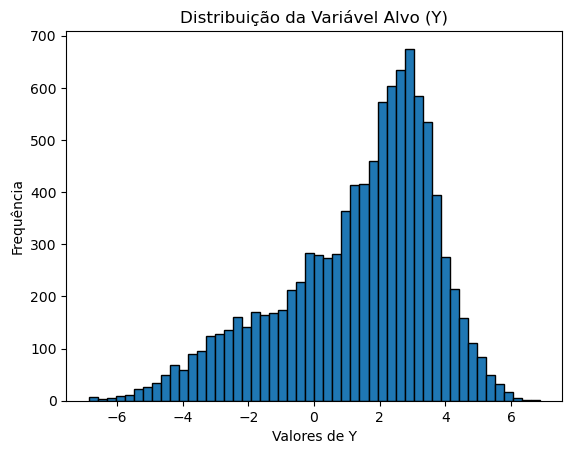

In [38]:
import matplotlib.pyplot as plt
plt.hist(target_data, bins=50, edgecolor='k')
plt.title("Distribuição da Variável Alvo (Y)")
plt.xlabel("Valores de Y")
plt.ylabel("Frequência")
plt.show()


The histogram illustrates the distribution of the target variable \( Y \) in the dataset. The x-axis represents the range of \( Y \) values, spanning approximately from -6.8 to 6.8, while the y-axis indicates the frequency of occurrences for each interval of \( Y \). The distribution appears to be unimodal and slightly skewed to the left, with the majority of \( Y \) values concentrated between 0 and 3. The peak frequency occurs near 2, as evidenced by the tallest bars in the histogram. At the extremes of the range, near -6 and 6, the frequency of \( Y \) values is notably lower, indicating that such values are rare in the dataset. This visualization aligns with the previously calculated descriptive statistics, providing a clear and concise overview of the distribution of \( Y \) values and their variability across the dataset.

### CNN

The create_cnn function defines the CNN architecture. It begins by reshaping the input data to a format suitable for convolutional operations, treating the features as a 1D sequence. The model includes two 1D convolutional layers with 32 and 64 filters, respectively, each using a kernel size of 3 and ReLU activation. These layers extract local patterns from the input data, such as dependencies or correlations between features. Each convolutional layer is followed by a MaxPooling layer, which downsamples the data to reduce its dimensionality while retaining the most significant features, thereby improving computational efficiency.

After the convolutional layers, the data is flattened into a single vector to prepare it for the fully connected layers. A dense layer with 64 neurons and ReLU activation is included to learn high-level feature representations. A dropout layer with a 30% dropout rate follows, helping to reduce overfitting by randomly deactivating neurons during training. The final layer is a dense output layer with one neuron and a linear activation function, which is appropriate for regression tasks where the output is a continuous variable. The model is compiled using the Adam optimizer, which dynamically adjusts learning rates for faster convergence, the mean squared error (MSE) as the loss function, and the mean absolute error (MAE) as a performance metric for evaluation.

In [39]:
def create_cnn(input_shape):
    model = Sequential([
        layers.Reshape((input_shape[0], 1), input_shape=input_shape),
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    print("CNN Summary:")
    print(model.summary())
    return model

The create_cnn function is called to instantiate the model, and the model is trained using the fit method. During training, 20% of the data is reserved for validation, allowing the model's generalization performance to be monitored. The training runs for 50 epochs, with a batch size of 32, enabling frequent weight updates and faster convergence. The training process adjusts the model's parameters, including filters, weights, and biases, to minimize the error on the training data while maintaining good performance on the validation set.

This CNN architecture is particularly advantageous because it leverages convolutional layers to extract hierarchical patterns, making it ideal for datasets with complex dependencies. The pooling layers and dropout further enhance its generalization by reducing overfitting and computational complexity. However, training CNNs can be computationally intensive, and the choice of hyperparameters, such as the number of filters, kernel size, and dropout rate, significantly impacts performance. From a biological perspective, this CNN model is well-suited for analyzing molecular descriptors or gene expression data, as it can capture local dependencies and intricate relationships between features. This makes it highly effective for tasks like predicting drug efficacy or modeling biological responses, where understanding subtle patterns in the data is crucial for generating meaningful predictions.

In [40]:
input_shape_cnn = (X_train.shape[1],)
cnn_model = create_cnn(input_shape_cnn)
cnn_history = cnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

CNN Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 19886, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 19884, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9942, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 9940, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4970, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 318080)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │    20,357,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,363,585 (77.68 MB)

 Trainable params: 20,363,585 (77.68 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 212ms/step - loss: 239.9471 - mae: 5.0846 - val_loss: 7.0870 - val_mae: 2.3198
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 213ms/step - loss: 6.9663 - mae: 2.2917 - val_loss: 6.9668 - val_mae: 2.2970
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 222ms/step - loss: 7.0612 - mae: 2.3083 - val_loss: 6.8226 - val_mae: 2.2688
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 226ms/step - loss: 6.8474 - mae: 2.2649 - val_loss: 6.6632 - val_mae: 2.2367
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 242ms/step - loss: 6.6172 - mae: 2.2306 - val_loss: 6.5020 - val_mae: 2.2028
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 284ms/step - loss: 6.4713 - mae: 2.2031 - val_loss: 6.3443 - val_mae: 2.1685
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 55s 275ms/step - loss: 6.2962 - mae: 2.1600 - val_loss: 6.1955 - val_mae: 2.1348
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 266ms/step - loss: 6.1977 - mae: 2.1411 - val_loss: 6.0589 - val_mae: 2.1017
Epoch 9/50
200/200 ━━━━━━

KeyboardInterrupt: 

In [ ]:
cnn_eval = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"CNN Mean Absolute Error (MAE) no conjunto de teste: {cnn_eval[1]:.4f}")